1. 搭建的神经网络，使用olivettiface数据集进行训练。
2. 结合归一化和正则化来优化网络模型结构，观察对比loss结果。
3. 尝试不同optimizer对模型进行训练，观察对比loss结果。
4. 注册kaggle并尝试激活Accelerator，使用GPU加速模型训练。

In [1]:
import torch 
import torch.nn as nn
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import DataLoader,TensorDataset

In [2]:
#导入数据
olivetti_faces = fetch_olivetti_faces(data_home='./face_data', shuffle=True)

train_data=torch.Tensor(olivetti_faces.data)
train_data[1]

tensor([0.7686, 0.7562, 0.7438,  ..., 0.4835, 0.6281, 0.6529])

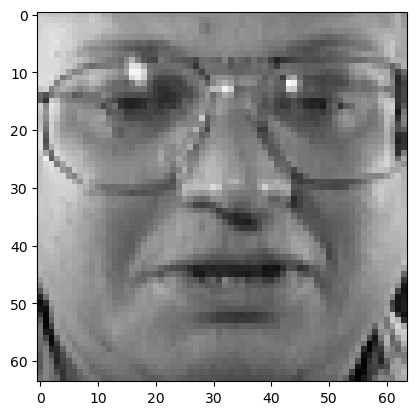

In [3]:
import matplotlib.pyplot as plt
face = olivetti_faces.images[1]
plt.imshow(face,cmap="gray")
plt.show()

In [4]:
images=torch.tensor(olivetti_faces.data)
target=torch.tensor(olivetti_faces.target)
target

tensor([13, 30, 34, 19, 24,  6, 15, 26, 14, 21,  3, 13, 11, 34,  1,  5, 29, 14,
        20, 19, 17, 26, 12, 34, 17, 31,  7,  1, 28, 10, 17, 30, 33, 22,  6,  7,
         9, 17, 17, 39, 10, 32,  0,  0, 29,  5, 37, 25, 15, 23, 24, 14, 29, 17,
        28, 31,  5,  1,  2,  4,  7, 27,  0, 35, 19, 37, 14,  0, 15, 31,  0, 26,
         6,  2, 10,  1, 36, 30, 36, 32, 33,  6,  5, 10, 30, 22, 12, 37, 39, 32,
        38, 25,  5,  0, 19, 14, 13, 39, 26, 36, 25,  6, 31, 15, 28, 34,  8, 34,
        15, 29,  9,  8, 29,  2, 36, 21, 25,  4, 23, 34,  9, 22, 23, 23, 37, 14,
         2, 25, 35, 16, 15, 39,  6, 24, 21, 10, 31, 19, 32,  1, 16, 18,  3, 11,
        26, 10, 35, 24, 23, 11, 33, 12, 28, 11, 21, 13, 27, 12, 19, 29, 28, 13,
         3, 37, 16,  3, 23,  9,  8,  6, 16, 28, 20, 39, 23, 28, 10,  4, 32, 39,
        22,  7, 13, 38, 22, 21,  2, 18, 36, 27,  5, 32, 35,  2,  0, 21, 15, 21,
        37, 22, 13, 23, 21, 27, 27, 30, 23,  3, 20, 39,  6,  2, 33,  4, 24, 12,
         9, 11, 16, 38, 38, 34,  4,  1, 

- 一、搭建的神经网络，使用olivettiface数据集进行训练。

In [5]:
#超参数
epochs = 10
lr=0.01
batch_size=64

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear=nn.Linear(4096,2048)
#         self.bn= nn.BatchNorm1d(2048)
        self.linear2 = nn.Linear(2048,1024)
#         self.bn2=nn.BatchNorm1d(1024)
        self.relu=nn.ReLU()
#         self.drop=nn.Dropout(0.2)
        self.linear3=nn.Linear(1024,40)
        
    def forward(self,x):
        out=self.linear(x)
#         out=self.bn(out)
        out=self.relu(out)
        out=self.linear2(out)
#         out=self.bn2(out)
        out-self.relu(out)
#         out=self.drop(out)
        final= self.linear3(out)
        return final
        
a=Net()

In [7]:
train_ds = TensorDataset(images,target)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
model=Net()

In [8]:
def train(epochs,model,train_dl,lr):
#     model.train()
    train_hist = []
    loss = nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    
    for epoch in range(epochs):
        running_loss=0.0
        correct=0
        total=0
        for data,target in train_dl:
            target = target.long() 
            out = model(data)
            loss_val = loss(out,target)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            
            _,pred=torch.max(out,1)
            correct += (pred==target).sum().item()
            total += data.size(0)
            running_loss += loss_val
        acc = correct/total*100
        r_loss=running_loss/len(train_dl)
        train_hist.append(r_loss.item())
        if epoch % 5 == 0:
            print(f"Epochs:{epoch},Loss:{r_loss.item():>.4f},acc:{acc:>.4f}")
    return train_hist
            

In [9]:
hists = train(epochs,model,train_dl,lr)

Epochs:0,Loss:193.3220,acc:2.0000
Epochs:5,Loss:3.7073,acc:2.5000


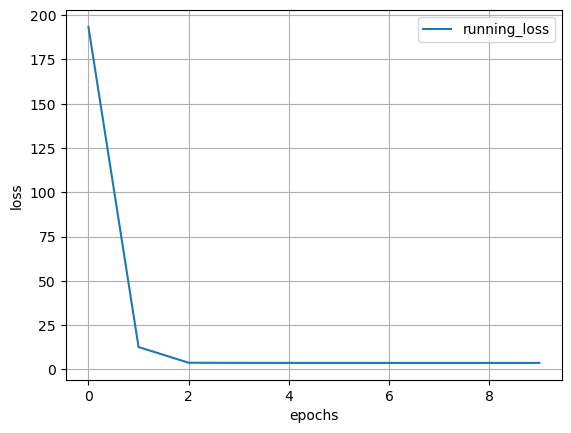

In [10]:
import matplotlib.pyplot as plt

plt.plot(hists,label="running_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

- 二、结合归一化和正则化来优化网络模型结构，观察对比loss结果。

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear=nn.Linear(4096,2048)
        self.bn= nn.BatchNorm1d(2048)
        self.linear2 = nn.Linear(2048,1024)
        self.bn2=nn.BatchNorm1d(1024)
        self.relu=nn.ReLU()
        self.drop=nn.Dropout(0.2)
        self.linear3=nn.Linear(1024,40)
        
    def forward(self,x):
        out=self.linear(x)
        out=self.bn(out)
        out=self.relu(out)
        out=self.linear2(out)
        out=self.bn2(out)
        out-self.relu(out)
        out=self.drop(out)
        final= self.linear3(out)
        return final
    
def train(epochs,model,train_dl,lr):
    model.train()
    train_hist = []
    loss = nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    
    for epoch in range(epochs):
        running_loss=0.0
        correct=0
        total=0
        for data,target in train_dl:
            target = target.long() 
            out = model(data)
            loss_val = loss(out,target)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            
            _,pred=torch.max(out,1)
            correct += (pred==target).sum().item()
            total += data.size(0)
            running_loss += loss_val
        acc = correct/total*100
        r_loss=running_loss/len(train_dl)
        train_hist.append(r_loss.item())
        if epoch % 5 == 0:
            print(f"Epochs:{epoch},Loss:{r_loss.item():>.4f},acc:{acc:>.4f}")
    return train_hist
            

Epochs:0,Loss:4.2608,acc:22.7500
Epochs:5,Loss:0.3762,acc:92.7500


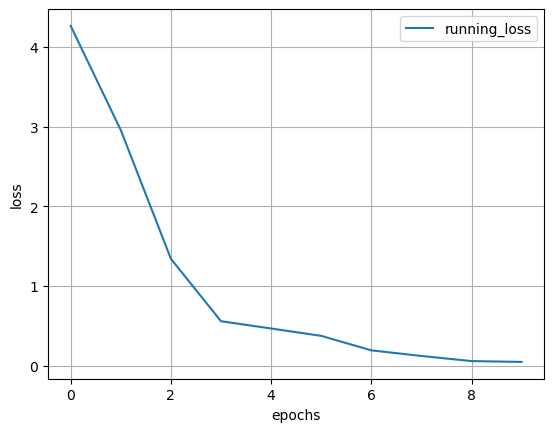

In [12]:
model=Net()
hists = train(epochs,model,train_dl,lr)
plt.plot(hists,label="running_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

- 三、使用不同optimizer对模型进行训练，观察对比loss结果。

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.models = nn.ModuleList([
            nn.Sequential(
                nn.Linear(4096,2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Linear(2048,1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024,40)
            ) for _ in range(3) 
        ])
    def forward(self,x):
        for model in self.models:
            final = model(x)
        return final
    
    def __iter__(self):
        return iter(self.models)
    
    def __len__(self):
        return len(self.models)

def train(epochs,model,train_dl,lr):
    model.train()
    train_hist = []
    loss = nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    
    for epoch in range(epochs):
        running_loss=0.0
        correct=0
        total=0
        for data,target in train_dl:
            target = target.long() 
            out = model(data)
            loss_val = loss(out,target)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            
            _,pred=torch.max(out,1)
            correct += (pred==target).sum().item()
            total += data.size(0)
            running_loss += loss_val
        acc = correct/total*100
        r_loss=running_loss/len(train_dl)
        train_hist.append(r_loss.item())
        if epoch % 5 == 0:
            print(f"Epochs:{epoch},Loss:{r_loss.item():>.4f},acc:{acc:>.4f}")
    return train_hist

Epochs:0,Loss:20.5029,acc:14.2500
Epochs:5,Loss:0.5035,acc:84.2500
Epochs:0,Loss:3.2466,acc:24.5000
Epochs:5,Loss:0.1118,acc:96.7500
Epochs:0,Loss:2.1569,acc:49.0000
Epochs:5,Loss:0.0320,acc:100.0000


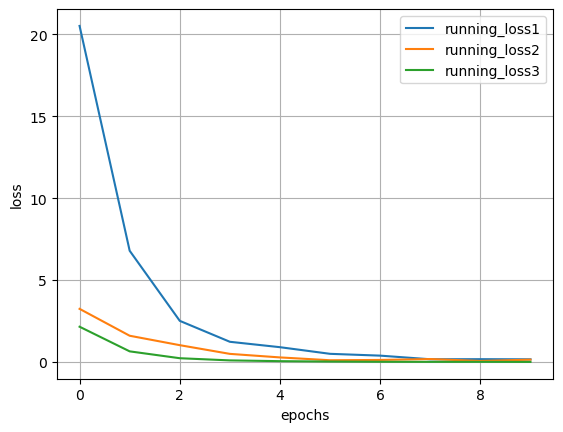

In [30]:
models=Net()
hists = [train(epochs,model,train_dl,lr) for model,lr in zip(models,[0.1,0.01,0.001])]
    
for i,hist in enumerate(hists):
    plt.plot(hist,label=f"running_loss{i+1}")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()